<a href="https://colab.research.google.com/github/tyoc213/fastai_xla_extensions/blob/explorations1/explore_nbs/Exploration_MNIST_TINY_Lenet_Adam_crete_opt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
VERSION = "20200707" #"nightly"  #"20200515" @param ["1.5" , "20200325", "nightly"]
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4994  100  4994    0     0  60168      0 --:--:-- --:--:-- --:--:-- 60168
Updating... This may take around 2 minutes.
Updating TPU runtime to pytorch-dev20200515 ...
Uninstalling torch-1.6.0a0+bf2bbd9:
  Successfully uninstalled torch-1.6.0a0+bf2bbd9
Uninstalling torchvision-0.7.0a0+a6073f0:
  Successfully uninstalled torchvision-0.7.0a0+a6073f0
Copying gs://tpu-pytorch/wheels/torch-nightly+20200515-cp36-cp36m-linux_x86_64.whl...
| [1 files][ 91.0 MiB/ 91.0 MiB]                                                
Operation completed over 1 objects/91.0 MiB.                                     
Copying gs://tpu-pytorch/wheels/torch_xla-nightly+20200515-cp36-cp36m-linux_x86_64.whl...
| [1 files][119.5 MiB/119.5 MiB]                                                
Operation completed over 1 objects/119.5 MiB.                        

In [2]:
!pip install https://github.com/fastai/fastcore/archive/master.zip
!pip install https://github.com/fastai/fastai2/archive/master.zip

  Using cached https://github.com/fastai/fastcore/archive/master.zip
  Created wheel for fastcore: filename=fastcore-0.1.18-cp36-none-any.whl size=28891 sha256=de681502a9e9d80e3392802b255ecda49ab0c2498fd9979eca93cd9348cda7db
  Stored in directory: /tmp/pip-ephem-wheel-cache-ad0q2j7x/wheels/68/af/c5/c8a9f7370515ab9b237b3fd59c04a0e7c5d4dedc7a6768a772
Successfully built fastcore
  Using cached https://github.com/fastai/fastai2/archive/master.zip
  Created wheel for fastai2: filename=fastai2-0.0.18-cp36-none-any.whl size=192058 sha256=75dc137019bd57828ebbcd6e38f608ae38a46f6871263f0e6420079bc3ac0fef
  Stored in directory: /tmp/pip-ephem-wheel-cache-h51aplnb/wheels/b2/28/3b/7a38644c6129e851e0db09b594949028266a62f4cb234fd1f3
Successfully built fastai2


In [3]:
from fastai2.vision.all import *

[('__call__', <function LevelMapper.__call__ at 0x7fe4787fc730>), ('__init__', <function LevelMapper.__init__ at 0x7fe4787fc6a8>)]
[('__call__', <function BalancedPositiveNegativeSampler.__call__ at 0x7fe47859d2f0>), ('__init__', <function BalancedPositiveNegativeSampler.__init__ at 0x7fe47859d268>)]
[('__init__', <function BoxCoder.__init__ at 0x7fe4785a8730>), ('decode', <function BoxCoder.decode at 0x7fe4785a88c8>), ('decode_single', <function BoxCoder.decode_single at 0x7fe4785a8950>), ('encode', <function BoxCoder.encode at 0x7fe4785a87b8>), ('encode_single', <function BoxCoder.encode_single at 0x7fe4785a8840>)]
[('__call__', <function Matcher.__call__ at 0x7fe4785a8620>), ('__init__', <function Matcher.__init__ at 0x7fe4785a8a60>), ('set_low_quality_matches_', <function Matcher.set_low_quality_matches_ at 0x7fe4785a86a8>)]
[('__init__', <function ImageList.__init__ at 0x7fe4785a8bf8>), ('to', <function ImageList.to at 0x7fe4785a8b70>)]
[('__init__', <function Timebase.__init__ at

In [4]:
path = untar_data(URLs.MNIST_TINY)
datablock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW),CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=GrandparentSplitter(),
    item_tfms=Resize(28),
    batch_tfms=[]
)
#datablock.summary(path)

In [5]:
class MyLenet(nn.Module):
    """Lenet with convs and F.max_pool2d"""
    def __init__(self):
        super(MyLenet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3) # set 3 for first item if RGB
        self.conv2 = nn.Conv2d(6,16,3)
        self.hiden4 = nn.Linear(400, 2) # 2 outputs (3 and 7) instead of 10
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = self.hiden4(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

class Lenet2(nn.Module):
    """Lenet with layers"""
    def __init__(self):
        super(Lenet2, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3) # set 3 for first item if RGB
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2) # Only 2 outputs (3 and 7) instead of 10
    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

(device(type='xla', index=1), (#2) ['3','7'], None)

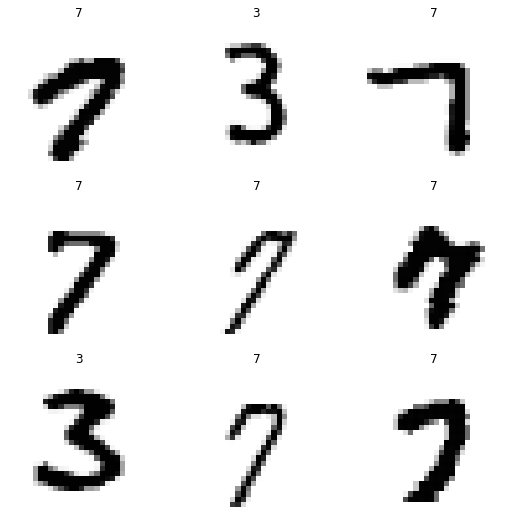

In [6]:
import torch_xla.core.xla_model as xm

tpu_device = xm.xla_device()
# Use same datablock, but load with TPU
dls_tpu = datablock.dataloaders(path, device=tpu_device)
dls_tpu.device, dls_tpu.vocab, dls_tpu.show_batch()


In [13]:
def print_local(msg):
  if True: return
  print(msg)

class CallbackXLA(Callback):
  def after_step(self):
    xm.optimizer_step(self.opt, barrier=True)


class XLAOptimProxy:
    def __init__(self,opt:Optimizer):
        self.opt = opt

    def xla_step(self):
        xm.optimizer_step(self.opt,barrier=True) # sync on gradient update

    def __getattr__(self,name):
        if name == 'step': # override proxying for step method
                print_local("calling xla_step")
                return getattr(self,'xla_step')
        # proxy everything else
        print_local(f"calling {name}")
        return getattr(self.opt,name)


@patch_to(ParamScheduler)
def _update_val(self, pct):
#        for n,f in self.scheds.items(): self.opt.set_hyper(n, f(pct))
        for n,f in self.scheds.items():
            v = f(pct)
            print_local(f"---------------------- A f(pct) = {v}")
            self.opt.set_hyper(n, v)

@patch_to(ParamScheduler)
def after_batch(self):
#        for p in self.scheds.keys(): self.hps[p].append(self.opt.hypers[-1][p])
        for p in self.scheds.keys():
            v = self.opt.hypers[-1][p]
            print_local(f"---------------------- B after_batch ParamScheduler {v}")
            self.hps[p].append(v)
@patch_to(Learner)
def create_opt(self):
        print_local("create_opt!!!")
        ooo = self.opt_func(self.splitter(self.model), lr=self.lr)
        prox = XLAOptimProxy(ooo)
        self.opt = prox
        if not self.wd_bn_bias:
            for p in self._bn_bias_state(True ): p['do_wd'] = False
        if self.train_bn:
            for p in self._bn_bias_state(False): p['force_train'] = True

proxyLearn = Learner(dls_tpu, Lenet2(), metrics=accuracy, opt_func=Adam)#, cbs=CallbackXLA)


In [15]:
proxyLearn.fit(50, 10e-3) # 0.05) NOTE: Im not sure if this works...!!! it is now 96!

calling set_hypers


epoch,train_loss,valid_loss,accuracy,time
0,0.015934,0.008114,0.997139,00:02
1,0.015063,0.051340,0.985694,00:01
2,0.013705,0.012020,0.995708,00:01
3,0.009627,0.025635,0.992847,00:01
4,0.007156,0.009010,0.995708,00:01
5,0.005273,0.007940,0.998569,00:02
6,0.003982,0.008264,0.998569,00:01
7,0.003049,0.006678,0.998569,00:01
8,0.002361,0.005485,0.998569,00:02
9,0.001844,0.004880,0.998569,00:02


calling xla_step
calling zero_grad
calling hypers
calling xla_step
calling zero_grad
calling hypers
calling xla_step
calling zero_grad
calling hypers
calling xla_step
calling zero_grad
calling hypers
calling xla_step
calling zero_grad
calling hypers
calling xla_step
calling zero_grad
calling hypers
calling xla_step
calling zero_grad
calling hypers
calling xla_step
calling zero_grad
calling hypers
calling xla_step
calling zero_grad
calling hypers
calling xla_step
calling zero_grad
calling hypers
calling xla_step
calling zero_grad
calling hypers
calling xla_step
calling zero_grad
calling hypers
calling xla_step
calling zero_grad
calling hypers
calling xla_step
calling zero_grad
calling hypers
calling xla_step
calling zero_grad
calling hypers
calling xla_step
calling zero_grad
calling hypers
calling xla_step
calling zero_grad
calling hypers
calling xla_step
calling zero_grad
calling hypers
calling xla_step
calling zero_grad
calling hypers
calling xla_step
calling zero_grad
calling hypers


calling set_hypers
calling state_dict


---------------------- A f(pct) = 1e-07
calling set_hyper
calling xla_step
calling zero_grad
calling hypers
calling hypers
---------------------- B after_batch ParamScheduler 1e-07
---------------------- A f(pct) = 1.202264434617413e-07
calling set_hyper
calling xla_step
calling zero_grad
calling hypers
calling hypers
---------------------- B after_batch ParamScheduler 1.202264434617413e-07
---------------------- A f(pct) = 1.4454397707459274e-07
calling set_hyper
calling xla_step
calling zero_grad
calling hypers
calling hypers
---------------------- B after_batch ParamScheduler 1.4454397707459274e-07
---------------------- A f(pct) = 1.7378008287493754e-07
calling set_hyper
calling xla_step
calling zero_grad
calling hypers
calling hypers
---------------------- B after_batch ParamScheduler 1.7378008287493754e-07
---------------------- A f(pct) = 2.0892961308540395e-07
calling set_hyper
calling xla_step
calling zero_grad
calling hypers
calling hypers
---------------------- B after_batch

SuggestedLRs(lr_min=8.31763736641733e-07, lr_steep=6.309573450380412e-07)

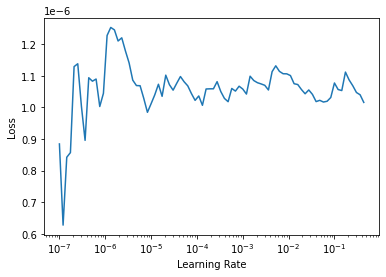

In [9]:
proxyLearn.lr_find()